In [1]:
import sys
sys.path.append("/n/fs/xl-diffbia/projects/minimal-diffusion")

In [2]:
import os
import cv2
from PIL import Image
import copy
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from domain_classifier.cifar_imagenet import DomainClassifier as DC_cifar_imgnet, count_cifar_imgnet
from domain_classifier.mnist_flip import DomainClassifier as DC_mnist, count_flip
from domain_classifier.fairface import DomainClassifier as DC_fairface, count_fairface, count_fairface_real
from domain_classifier.celeba import DomainClassifier as DC_celeba

import utils

/n/fs/xl-diffbia/software/anaconda3/envs/diffusion-bias/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ArrayToImageLabelShow(Dataset):
    def __init__(
        self,
        samples,
        labels,
        mode, # RGB or L-gray
        transform,
        transform_show,
        target_transform
    ):
        super().__init__()

        # convert from numpy array
        self.samples = samples
        if labels is not None:
            self.labels = labels
        else:
            self.labels = None
        # assert in valid form
        if self.samples.min() >= 0 and self.samples.max() <= 1:
            self.samples = (self.samples * 255).astype("uint8")
        elif self.samples.min() >= -1 and self.samples.max() <= 1:
            self.samples = (127.5 * (self.samples + 1)).astype("uint8")
        else:
            assert self.samples.min() >= 0 and self.samples.max() <= 255
        
        assert len(self.samples.shape) == 4, "Images must be a batch"
        if self.labels is not None:
            assert self.samples.shape[0] == self.labels.shape[0], "Number of images and labels must match"
        self.num_items = self.samples.shape[0]
        print(f"Converting {self.num_items} number of samples")

        # transformation
        self.transform = transform
        self.transform_show = transform_show
        self.target_transform = target_transform

        # 3 channel or 1 channel
        self.mode = mode

    def __len__(self):
        return self.num_items
    
    def __getitem__(self, index):
        image = self.samples[index] # height x width x num_channels
        if self.labels is not None:
            label = self.labels[index]
        image = Image.fromarray(np.squeeze(image), mode=self.mode)

        if self.transform is not None:
            image_batch = self.transform(image)
        if self.transform_show is not None:
            image_show = self.transform_show(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        
        if self.labels is not None:
            return image_show, image_batch, label # image, class-condition label
        else:
            return image_show, image_batch, torch.randint(1, size=(1,))

In [4]:
def show_image_row(image_batch, nmax=4):
    plt.close() # close previous plot
    fig, ax = plt.subplots(figsize=(16, 16 * nmax))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((image_batch.detach()[:nmax]), nrow=nmax).permute(1, 2, 0))
    plt.show()

In [5]:
# gender classifier
classifier = DC_fairface(
                num_classes = 2,
                arch = "resnet50",
                pretrained = True,
                learning_rate = 0.0001,
                weight_decay = 0.00001,
                device = "cuda"
            )
classifier.load("./logs/2023-07-20/fairface/domain_classifier/bs64_lr0.0001_decay1e-05/ckpt/model_param_final.pth")
classifier.eval()

Loading model checkpoint from ./logs/2023-07-20/fairface/domain_classifier/bs64_lr0.0001_decay1e-05/ckpt/model_param_final.pth.


DomainClassifier(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [6]:
transform_test = transforms.Compose(
                        [
                            transforms.Resize(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized by imagenet mean std
                        ]
                    )
transform_test_show = transforms.Compose(
                        [
                            transforms.Resize(224),
                            transforms.PILToTensor()
                        ]
                    )

In [ ]:
# constant
batch_size = 10
num_datapoint = 50

### male = 0.5, female = 0.5, cfg = 10.0

In [7]:
# change classifier-free guidance value
cfg_w = 10.0
# change domain ratios
female_ratio, male_ratio = 0.5, 0.5
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [8]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

Converting 50000 number of samples


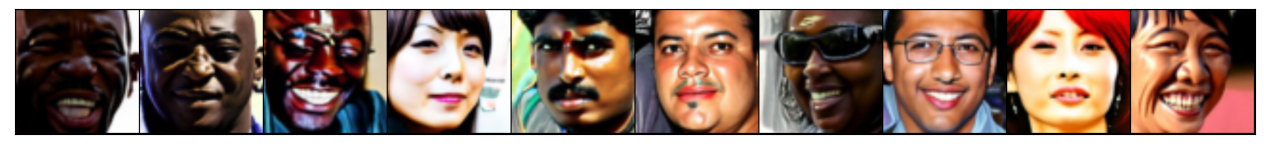

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


automatic predictions:  [1 1 1 0 1 1 0 1 0 0]
human predictions:  [1 1 1 0 1 1 1 1 0 0]


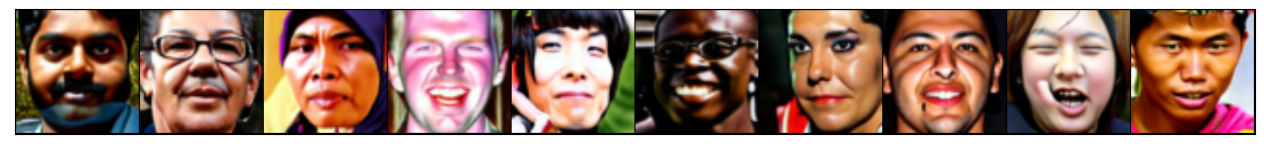

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


automatic predictions:  [1 0 0 1 1 1 0 1 0 1]
human predictions:  [1 1 0 1 0 1 0 2 0 1]


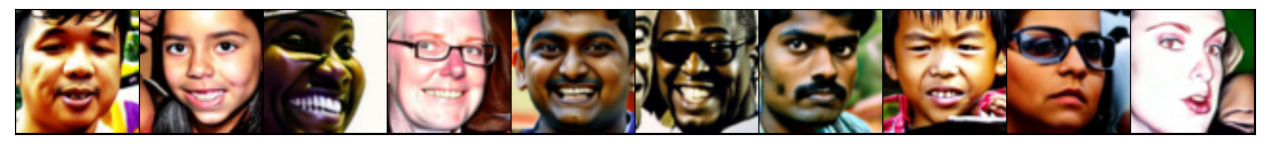

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


automatic predictions:  [1 0 0 0 1 0 1 1 0 0]
human predictions:  [1 0 0 0 1 1 1 1 0 0]


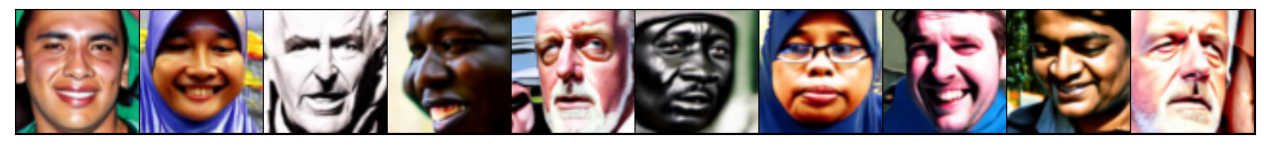

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


automatic predictions:  [1 0 1 1 1 1 0 1 1 1]
human predictions:  [1 0 1 1 1 1 0 1 0 1]


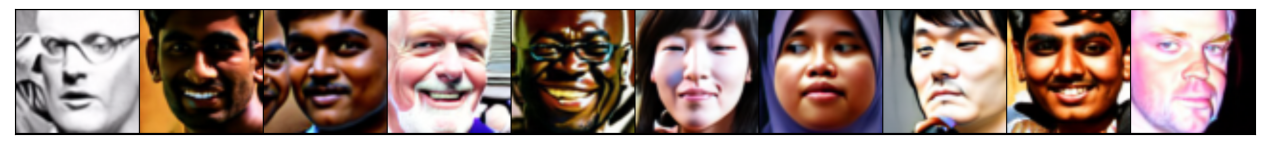

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


automatic predictions:  [1 1 1 1 1 0 0 1 1 1]
human predictions:  [1 1 1 1 1 0 0 1 1 1]
Perceived accuracy: 0.898


In [13]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.5, female = 0.5, cfg = 5.0

In [ ]:
# change classifier-free guidance value
cfg_w = 5.0
# change domain ratios
female_ratio, male_ratio = 0.5, 0.5
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.5, female = 0.5, cfg = 0.0

In [ ]:
# change classifier-free guidance value
cfg_w = 0.0
# change domain ratios
female_ratio, male_ratio = 0.5, 0.5
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.9, female = 0.1, cfg = 10.0

In [ ]:
# change classifier-free guidance value
cfg_w = 10.0
# change domain ratios
female_ratio, male_ratio = 0.9, 0.1
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.9, female = 0.1, cfg = 5.0

In [ ]:
# change classifier-free guidance value
cfg_w = 5.0
# change domain ratios
female_ratio, male_ratio = 0.1, 0.9
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.9, female = 0.1, cfg = 0.0

In [ ]:
# change classifier-free guidance value
cfg_w = 0.0
# change domain ratios
female_ratio, male_ratio = 0.1, 0.9
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [14]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

Converting 50000 number of samples


In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.1, female = 0.9, cfg = 10.0

In [ ]:
# change classifier-free guidance value
cfg_w = 10.0
# change domain ratios
female_ratio, male_ratio = 0.9, 0.1
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.1, female = 0.9, cfg = 5.0

In [ ]:
# change classifier-free guidance value
cfg_w = 5.0
# change domain ratios
female_ratio, male_ratio = 0.9, 0.1
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))

### male = 0.1, female = 0.9, cfg = 0.0

In [ ]:
# change classifier-free guidance value
cfg_w = 0.0
# change domain ratios
female_ratio, male_ratio = 0.9, 0.1
# change path to sampled images and labels
file_path = os.path.join(
            "./logs/2023-07-25/fairface", f"female{female_ratio}_male{male_ratio}",
            "UNet_diffusionstep_1000_samplestep_250_condition_True_lr_0.0001_bs_128_dropprob_0.1/samples_ema",
            f"fairface_gendersubset_f{female_ratio}_m{male_ratio}_ema_num50000_guidance{cfg_w}.npz"
            )

file_load = np.load(file_path, allow_pickle=True)
sampled_images = file_load['arr_0'] # shape = num_samples x height x width x n_channel
labels = file_load['arr_1'] # empty if class_cond = False

In [ ]:
domain_dataset = ArrayToImageLabelShow(
                        samples = sampled_images,
                        labels = None,
                        mode = "RGB",
                        transform = transform_test,
                        transform_show = transform_test_show,
                        target_transform = None
                    )
domain_dataloader = DataLoader(
                        domain_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 4
                    )

In [ ]:
num_show, num_count, num_correct = 0, 0, 0
prob_list = []
for image_show, image_batch, _ in iter(domain_dataloader):
    # clear_output(wait=True)
    with torch.no_grad():
        
        # show image
        show_image_row(image_show, nmax=10)
        
        # automatic evaluation
        syn_pred = classifier.predict(image_batch)
        syn_pred_prob = syn_pred.detach().cpu().numpy() # num_samples x 2
        # return predicted probability histogram
        prob_list.extend(np.squeeze(syn_pred_prob[:, 0])) # (num_samples, )
        # return binary predicted counts
        syn_preds = torch.argmax(syn_pred, dim=-1)
        syn_preds = syn_preds.detach().cpu().numpy() # (num_samples, )
    
    # collect human evaluation
    human_preds = []
    for idx in range(batch_size):
        human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
        human_preds.append(human_value)
    human_preds = np.array(human_preds, dtype=int)
    
    print("automatic predictions: ", syn_preds)
    print("human predictions: ", human_preds)
    
    # accuracy
    # ignore unsure samples
    confident_index = np.argwhere(human_preds != 2)
    human_preds = human_preds[confident_index]
    syn_preds = syn_preds[confident_index]
    num_show += batch_size
    num_count += len(confident_index)
    num_correct += np.sum(syn_preds == human_preds)
    
    if num_show >= num_datapoint:
        break

print("Perceived accuracy: {:.3f}".format(num_correct / num_count))